In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import imageio
import os
from tqdm import tqdm  # For progress bars

filename = 'run_sponge=10%_Ro=1.5_δ=0.2_Bu=1.5.nc' #remember.nc at the end
ds = xr.open_dataset(filename, engine = 'netcdf4', decode_times=False)


# Non-dimensionalising timescale

f = 1e-4

# Rescale time: convert seconds to non-dimensional time = f * t
# Ensure 'time' is in seconds (if it's in days, convert to seconds first)
time = ds.time.values
nondim_time =  time * f 


# Add non-dimensional time to dataset for convenience
ds = ds.assign_coords(nondim_time=("time", nondim_time))


<xarray.Dataset> Size: 20MB
Dimensions:  (x_caa: 240, x_faa: 241, z_aac: 20, z_aaf: 21, time: 208)
Coordinates:
  * time     (time) float64 2kB 0.0 600.0 1.2e+03 ... 1.236e+05 1.242e+05
  * x_faa    (x_faa) float32 964B -2.5e+05 -2.479e+05 ... 2.479e+05 2.5e+05
  * x_caa    (x_caa) float32 960B -2.49e+05 -2.469e+05 ... 2.469e+05 2.49e+05
  * z_aaf    (z_aaf) float32 84B -1e+03 -950.0 -900.0 ... -100.0 -50.0 0.0
  * z_aac    (z_aac) float32 80B -975.0 -925.0 -875.0 ... -125.0 -75.0 -25.0
Data variables:
    Δx_caa   (x_caa) float32 960B ...
    Δx_faa   (x_faa) float32 964B ...
    Δz_aac   (z_aac) float32 80B ...
    Δz_aaf   (z_aaf) float32 84B ...
    b        (time, z_aac, x_caa) float32 4MB ...
    u        (time, z_aac, x_faa) float32 4MB ...
    v        (time, z_aac, x_caa) float32 4MB ...
    w        (time, z_aaf, x_caa) float32 4MB ...
    ζ        (time, z_aaf, x_faa) float32 4MB ...
Attributes:
    Julia:                 This file was generated using Julia Version 1.11.5...
    Oceananigans:          This file was generated using Oceananigans v0.96.35
    date:                  This file was generated on 2025-07-20T10:47:02.644...
    interval:              600.0
    output time interval:  Output was saved every 10 minutes.
    schedule:              TimeInterval

## Buoyancy Animation

In [ ]:
# contours working

b = ds['b'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, b_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max(), color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_buoyancy.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 122/122 [00:22<00:00,  5.39it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_23904\599976280.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1073, 586) to (1088, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Along front velocity (u)

In [ ]:
#contour not working

b = ds['b'].load()  # Load only after preprocessing
u = ds['u'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time.nondim_time)//100)  # Target ~100 frames max
selected_times = ds.time.nondim_time[::time_step]


# 3. Pre-compute plot limits
vmin, vmax = float(u.quantile(0.05)), float(w.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    u_data = u.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, u_data,
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    
    #ax.contour(x_km, ds.z_aac.values, b_data,
      #       levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, along front velocity (u)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() +  2*x_km.max()/10 , color='0.5', linestyle='--') #note x.max() = Lx/2
    ax.axvline(x_km.max() - 2*x_km.max() / 10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time.nondim_time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_animation_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

## Along jet velocity (v)

In [ ]:
#contour working

b = ds['b'].load()  # Load only after preprocessing
v = ds['v'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time.nondim_time)//100)  # Target ~100 frames max
selected_times = ds.time.nondim_time[::time_step]


# 3. Pre-compute plot limits
vmin, vmax = float(v.quantile(0.05)), float(v.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    v_data = v.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, v_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, along jet velocity (v)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max(), color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time.nondim_time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 122/122 [00:27<00:00,  4.37it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_23904\507191069.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1073, 586) to (1088, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Vertical velocity (w)

In [ ]:
#Contour not working

w = ds['w'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(w.quantile(0.05)), float(w.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    w_data = w.isel(time=i).values
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, w_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aac.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Vertical velocity (v)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_animation_new.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 104/104 [00:36<00:00,  2.85it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_23904\2374150182.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1076, 586) to (1088, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


ValueError: All images in a movie should have same size

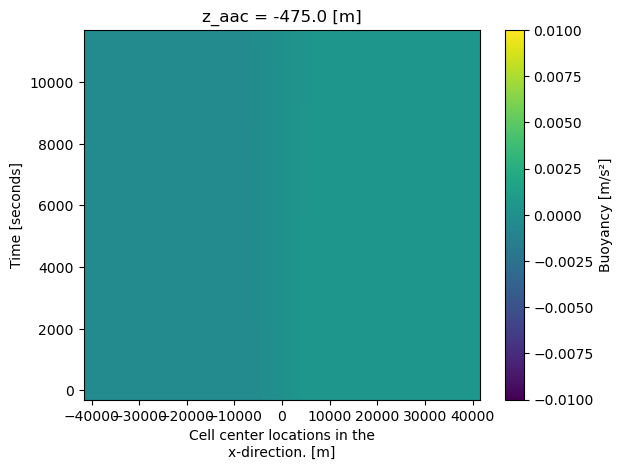

In [45]:
ds.b[:20,10,100:140].plot(vmin = -0.01, vmax = 0.01)